# 03 - Aprofundamento em Exploração e Alisamento Exponencial
- Métodos de Exploração:
    - Interactive Graphs: hvPlot
    - Decomposição de Séries
    - Teste de Estacionariedade
- Alisamento Exponencial Duplo e Triplo

### Preparação


In [32]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.datasets import co2, get_rdataset
import hvplot.pandas
import hvplot as hv
file = Path('/Users/danielferreira/Documents/git/classes/ASN/Séries Temporais/dados/closing_price.csv')
closing_price = pd.read_csv(file, index_col='Date',parse_dates=True)
co2_df = co2.load_pandas().data
co2_df = co2_df.ffill()
air_passengers = get_rdataset("AirPassengers")
airp_df = air_passengers.data
import warnings
warnings.filterwarnings('ignore')
airp_df.index = pd.date_range('1949', '1961', freq='M')
airp_df.drop(columns=['time'], inplace=True)
airp_df.reset_index().rename(columns={'value':'passengers', 'index':'date'}).to_csv('/Users/danielferreira/Documents/git/classes/ASN/Séries Temporais/dados/air_passenger.csv', index=False)
plt.rcParams["figure.figsize"] = [12, 5]

# Visualização de Séries Temporais
Já aprendemos como  usar o plot do pandas:

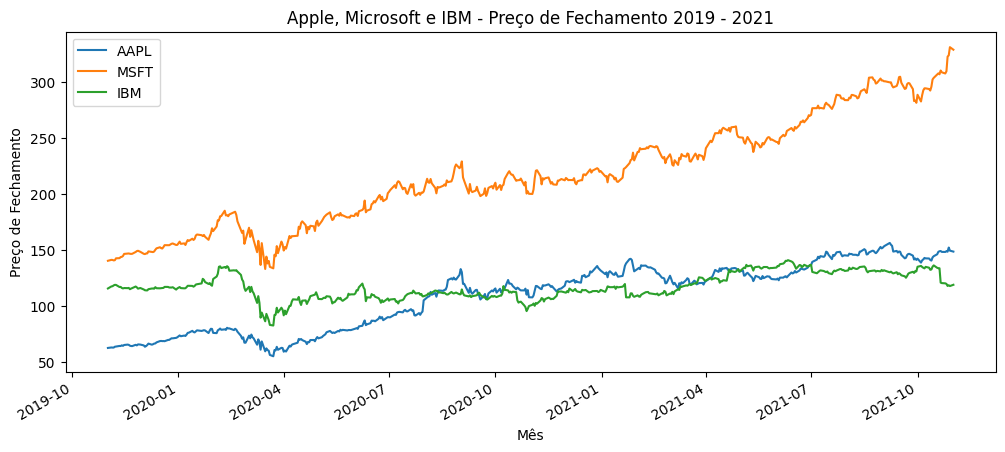

In [33]:
start_date = '2019'
end_date = '2021'
plot = closing_price.plot(title=f'Apple, Microsoft e IBM - Preço de Fechamento {start_date} - {end_date}',ylabel= 'Preço de Fechamento', xlabel='Mês')

Vou normalizar os dados dividindo os valores pelo primeiro valor de cada série. Vou também trocar o style:

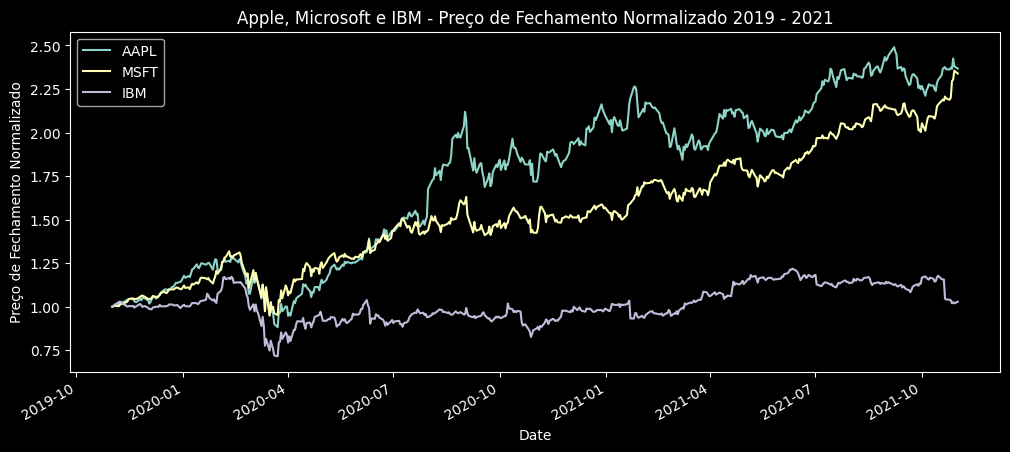

In [34]:
plt.style.use("dark_background")
closing_price_n = closing_price.div(closing_price.iloc[0])
plot = closing_price_n.plot(title=f'Apple, Microsoft e IBM - Preço de Fechamento Normalizado {start_date} - {end_date}',ylabel= 'Preço de Fechamento Normalizado')

Em séries temporais, o hvplot possibilita vermos a série de uma forma interativa:

In [35]:
closing_price_n.hvplot(title=f'Apple, Microsoft e IBM - Preço de Fechamento Normalizado {start_date} - {end_date}')

:NdOverlay   [Variable]
   :Curve   [Date]   (value)

O hvplot possui opções bem interessantes para visualizarmos as séries:

In [36]:
closing_price.hvplot(width=300, subplots=True)

:NdLayout   [Variable]
   :Curve   [Date]   (value)

### Gráficos de sazonalidade

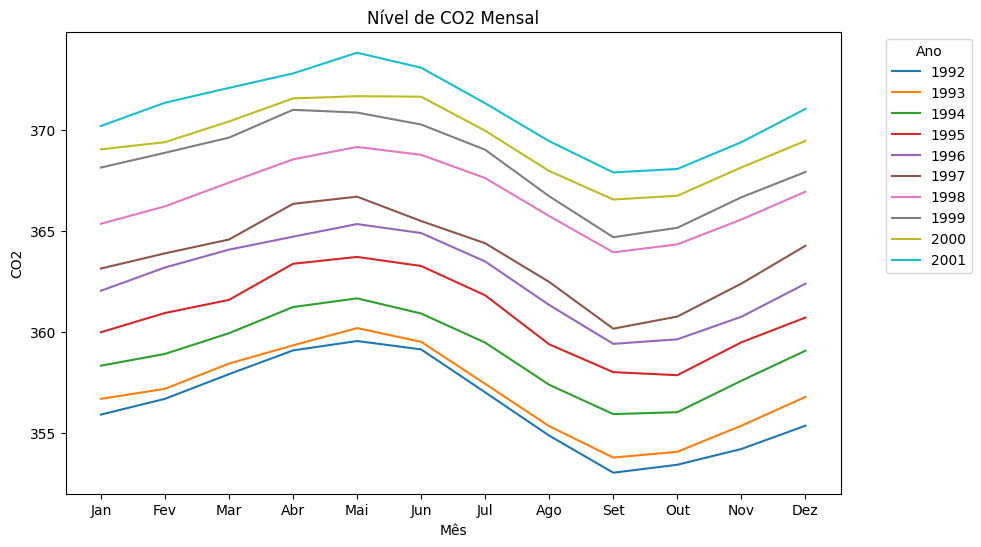

In [37]:
co2_month = co2_df.resample('MS').mean()
co2_month = co2_month[co2_month.index.year > 1991]
co2_month['Year'] = co2_month.index.year
co2_month['Month'] = co2_month.index.month
co2_month = co2_month.reset_index()
plt.style.use("default")
plt.figure(figsize=(10, 6))
sns.lineplot(data=co2_month, x='Month', y='co2', hue='Year', palette='tab10')
plt.xlabel('Mês')
plt.ylabel('CO2')
plt.xticks(ticks=co2_month['Month'].unique(), labels=['Jan', 'Fev', 'Mar', 'Abr', 'Mai', 'Jun', 'Jul', 'Ago', 'Set', 'Out', 'Nov', 'Dez'])
plt.title('Nível de CO2 Mensal')
plt.legend(title='Ano', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

Tem quem prefira visualizar os meses em um círculo:

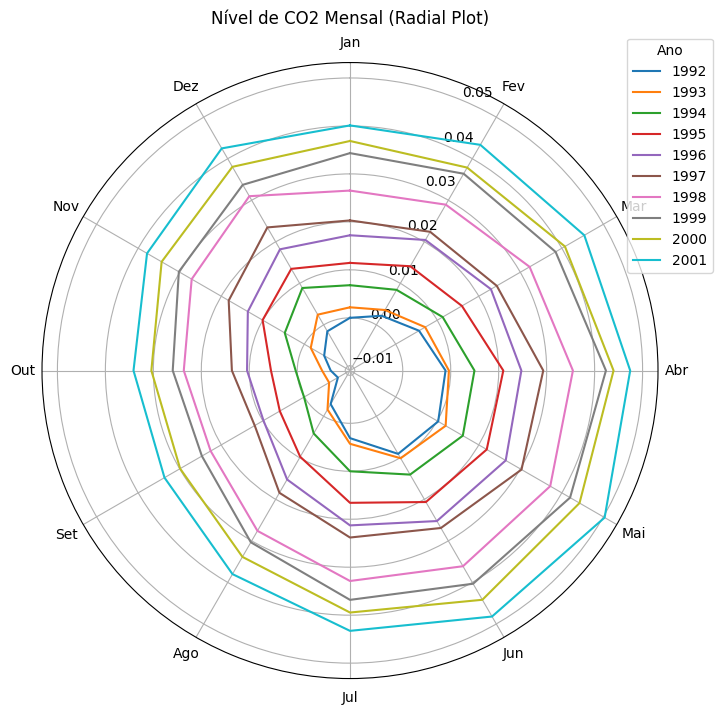

In [38]:
plt.figure(figsize=(10, 8))
ax = plt.subplot(111, polar=True)
co2_month['Month_rad'] = (co2_month['Month']-1) * (2 * np.pi / 12)
co2_month['co2_normalizado'] = (co2_month['co2']/co2_month['co2'][0])-1
years = co2_month['Year'].unique()
palette = sns.color_palette("tab10", len(years))
for i, year in enumerate(years):
    data = co2_month[co2_month['Year'] == year]
    data = pd.concat([data, data.iloc[[0]]])
    ax.plot(data['Month_rad'], data['co2_normalizado'], label=str(year), color=palette[i])

ax.set_theta_direction(-1) 
ax.set_theta_offset(np.pi / 2.0)  
ax.set_xticks(np.linspace(0, 2 * np.pi, 12, endpoint=False))
ax.set_xticklabels(['Jan', 'Fev', 'Mar', 'Abr', 'Mai', 'Jun', 'Jul', 'Ago', 'Set', 'Out', 'Nov', 'Dez'])
ax.set_title('Nível de CO2 Mensal (Radial Plot)', va='bottom')
plt.legend(title='Ano', bbox_to_anchor=(1.1, 1.05))
plt.show()

### Decomposição de uma série:
Métodos:

- Hodrick-Prescott: Extrai a Tendência dos dados 
    - hp_filter
- Seasonal-Trend LOESS (Locally Estimated Sacatterplot Smoothing)
    - seasonal_decompose (Aditivo e Multiplicativo)
    - STL (Opção robusta porém assume relacionamento aditivo)
- Gráficos de sazonalidade.

### seasonal_decompose (Aditivo)

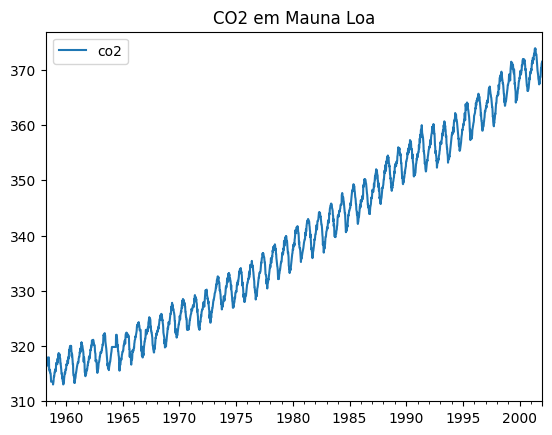

In [39]:
import statsmodels as sm
from statsmodels.tsa.seasonal import seasonal_decompose, STL
plt.style.use('default')
plpt = co2_df.plot(title='CO2 em Mauna Loa')

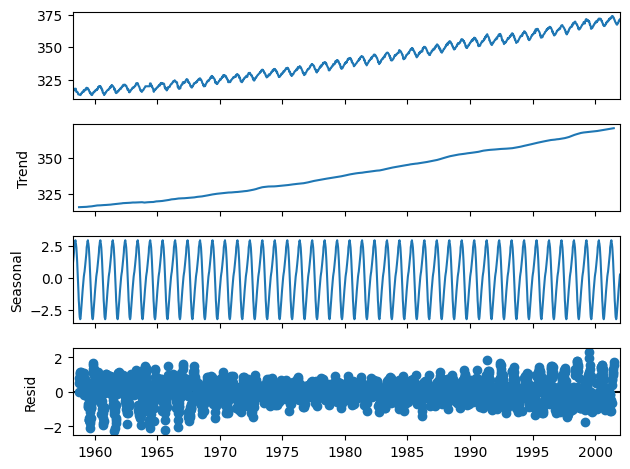

In [40]:
co2_decomposed = seasonal_decompose(co2_df,model='additive')
plot = co2_decomposed.plot()

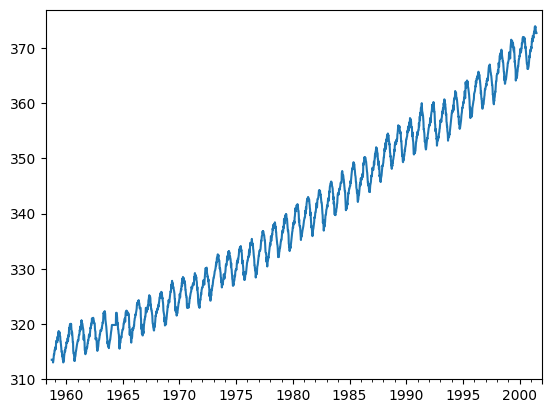

In [41]:
plot = (co2_decomposed.trend + 
     co2_decomposed.seasonal + 
     co2_decomposed.resid).plot()

In [42]:
df = pd.read_csv('/Users/danielferreira/Documents/git/classes/ASN/Séries Temporais/dados/netflix_titles.csv')
df['date_added']=pd.to_datetime(df['date_added'], format='%B %d, %Y', errors = 'coerce')
df.index = df['date_added']
lancamentos = df.set_index('date_added').resample('MS').size()

In [43]:
lancamentos = lancamentos[lancamentos.index.year>2015]

<Axes: xlabel='date_added'>

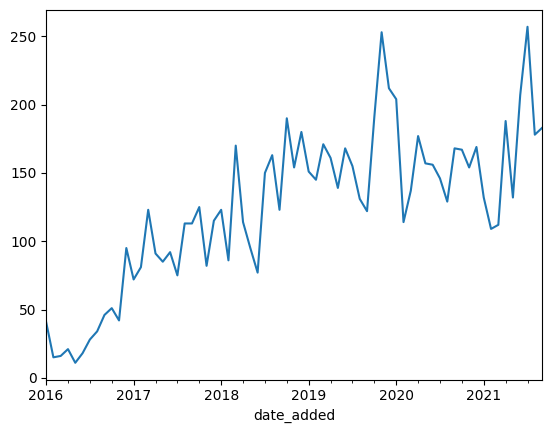

In [44]:
lancamentos.plot()

In [45]:
lancamentos_dec = seasonal_decompose(lancamentos,model='additive')

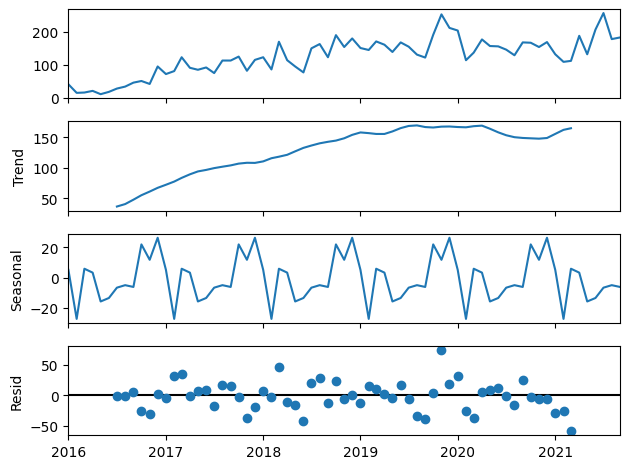

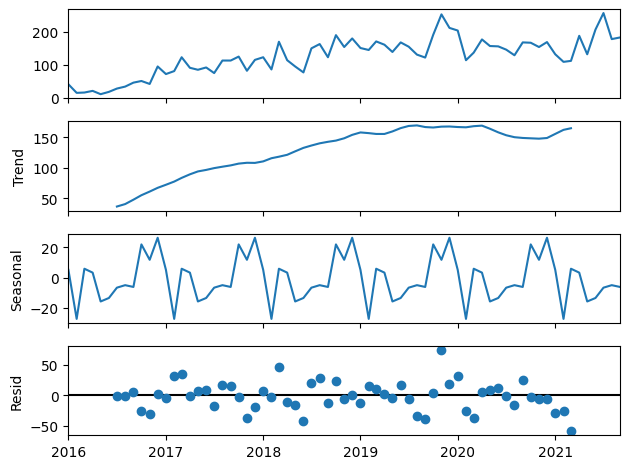

In [46]:
lancamentos_dec.plot()

### seasonal_decompose (Multiplicativo)

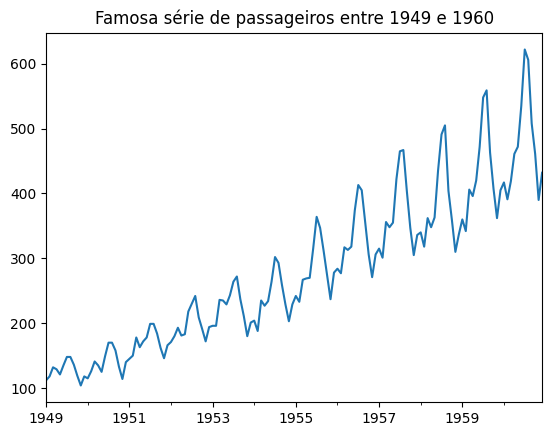

In [47]:
plot = airp_df['value'].plot(title='Famosa série de passageiros entre 1949 e 1960')

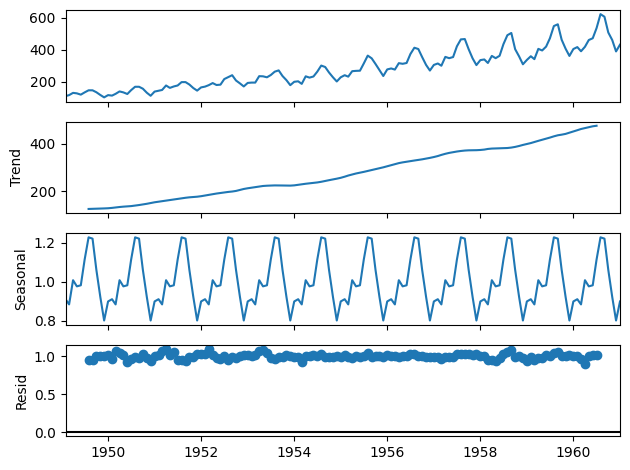

In [48]:
air_decomposed = seasonal_decompose(airp_df,model='multiplicative')
plot = air_decomposed.plot()

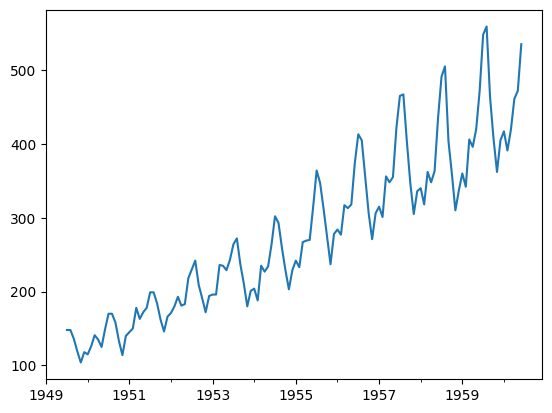

In [49]:
plot = (air_decomposed.trend * 
     air_decomposed.seasonal * 
     air_decomposed.resid).plot()

### STL (Opção aditiva apenas mas com robust=True)

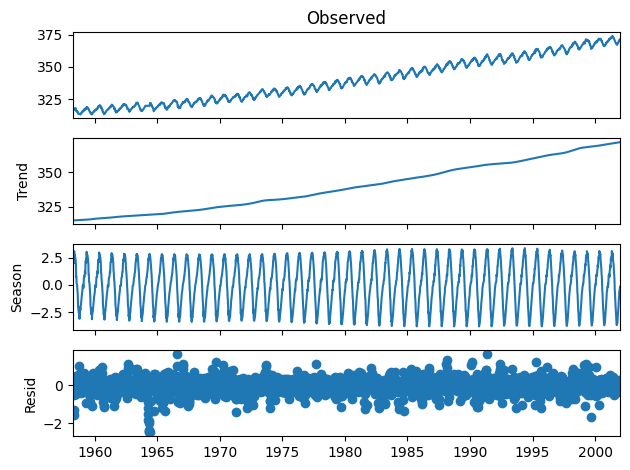

In [59]:
co2_stl = STL(
    co2_df, 
    seasonal=13, 
    robust=True).fit()
plot = co2_stl.plot()

### Hodrick - Prescott Filter

<Axes: >

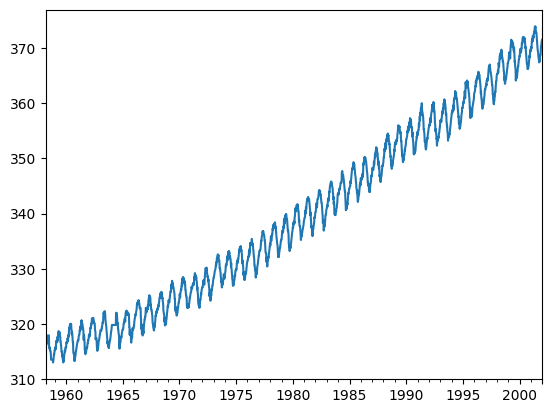

In [51]:
co2_df['co2'].plot()

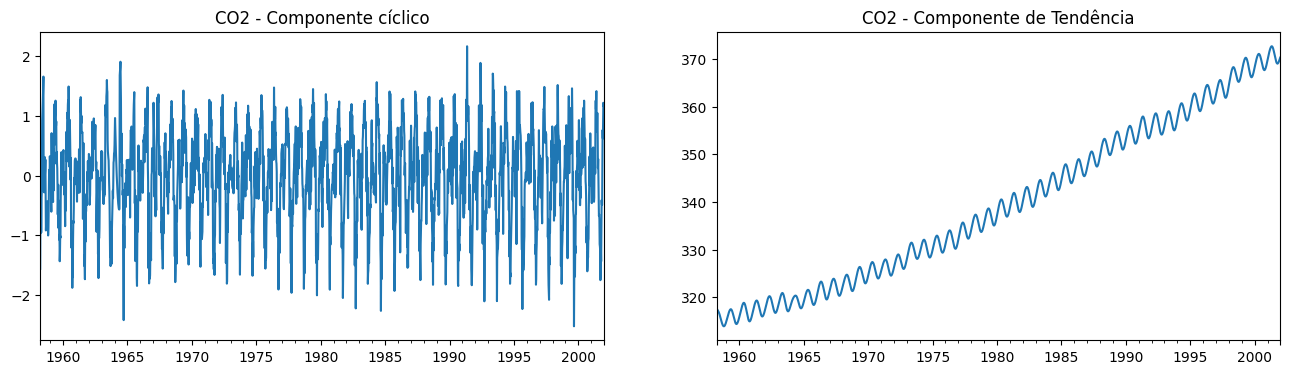

In [52]:
plt.style.use("default")
from statsmodels.tsa.filters.hp_filter import hpfilter
co2_cyclic, co2_trend = hpfilter(co2_df)
fig, ax = plt.subplots(1,2, figsize=(16, 4))
co2_cyclic.plot(ax=ax[0], title='CO2 - Componente cíclico')
co2_trend.plot(ax=ax[1], title='CO2 - Componente de Tendência')
plt.show()

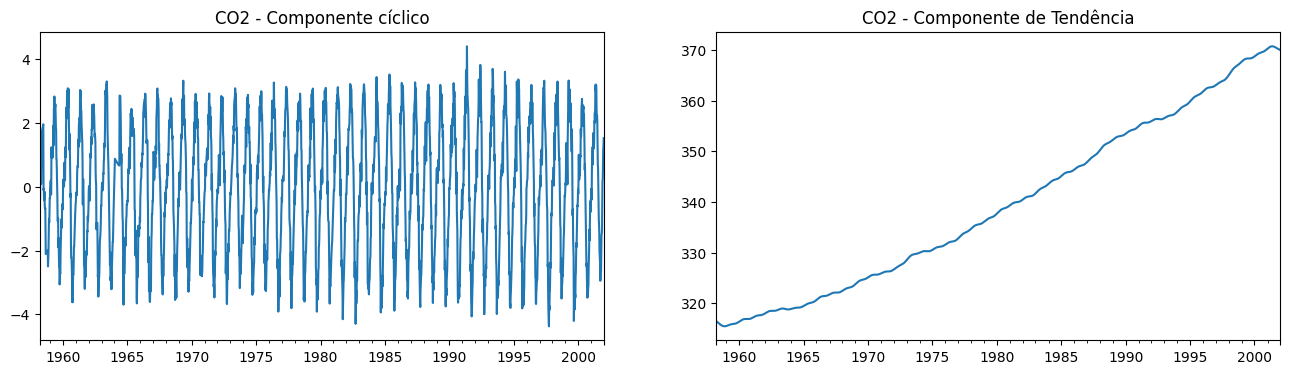

In [53]:
lamb = 100000
co2_cyclic, co2_trend = hpfilter(co2_df, lamb=lamb)
fig, ax = plt.subplots(1,2, figsize=(16, 4))
co2_cyclic.plot(ax=ax[0], title='CO2 - Componente cíclico')
co2_trend.plot(ax=ax[1], title='CO2 - Componente de Tendência')
plt.show()

### Testeando a Estacionariedade


In [63]:
def print_results(output, test='adf', alpha=0.05):
    
    test_score = output[0]
    pval = output[1]
    
    decision = 'Não Estacionário'
    if test == 'adf':
        if pval < alpha:
            decision = 'Estacionário'
    elif test=='kpss':
        if pval >= alpha:
            decision = 'Estacionário'
            
    output_dict = {
    'Estatística do Teste': test_score,
    'p-valor': pval,
    'Decisão': decision
    }  
    return pd.Series(output_dict, name=test)

In [62]:
from statsmodels.tsa.stattools import adfuller, kpss
adf_output = adfuller(co2_df)
kpss_output = kpss(co2_df)
pd.concat([
print_results(adf_output, 'adf'),
print_results(kpss_output, 'kpss')
], axis=1)

,adf,kpss
Estatística do Teste,0.046051,7.649196
p-valor,0.962179,0.01
Decisão,Não Estacionário,Não Estacionário


In [64]:
adf_output = adfuller(lancamentos)
kpss_output = kpss(lancamentos)
pd.concat([
print_results(adf_output, 'adf'),
print_results(kpss_output, 'kpss')
], axis=1)

,adf,kpss
Estatística do Teste,-2.875306,1.185039
p-valor,0.048296,0.01
Decisão,Estacionário,Não Estacionário


### Alisamento Exponencial

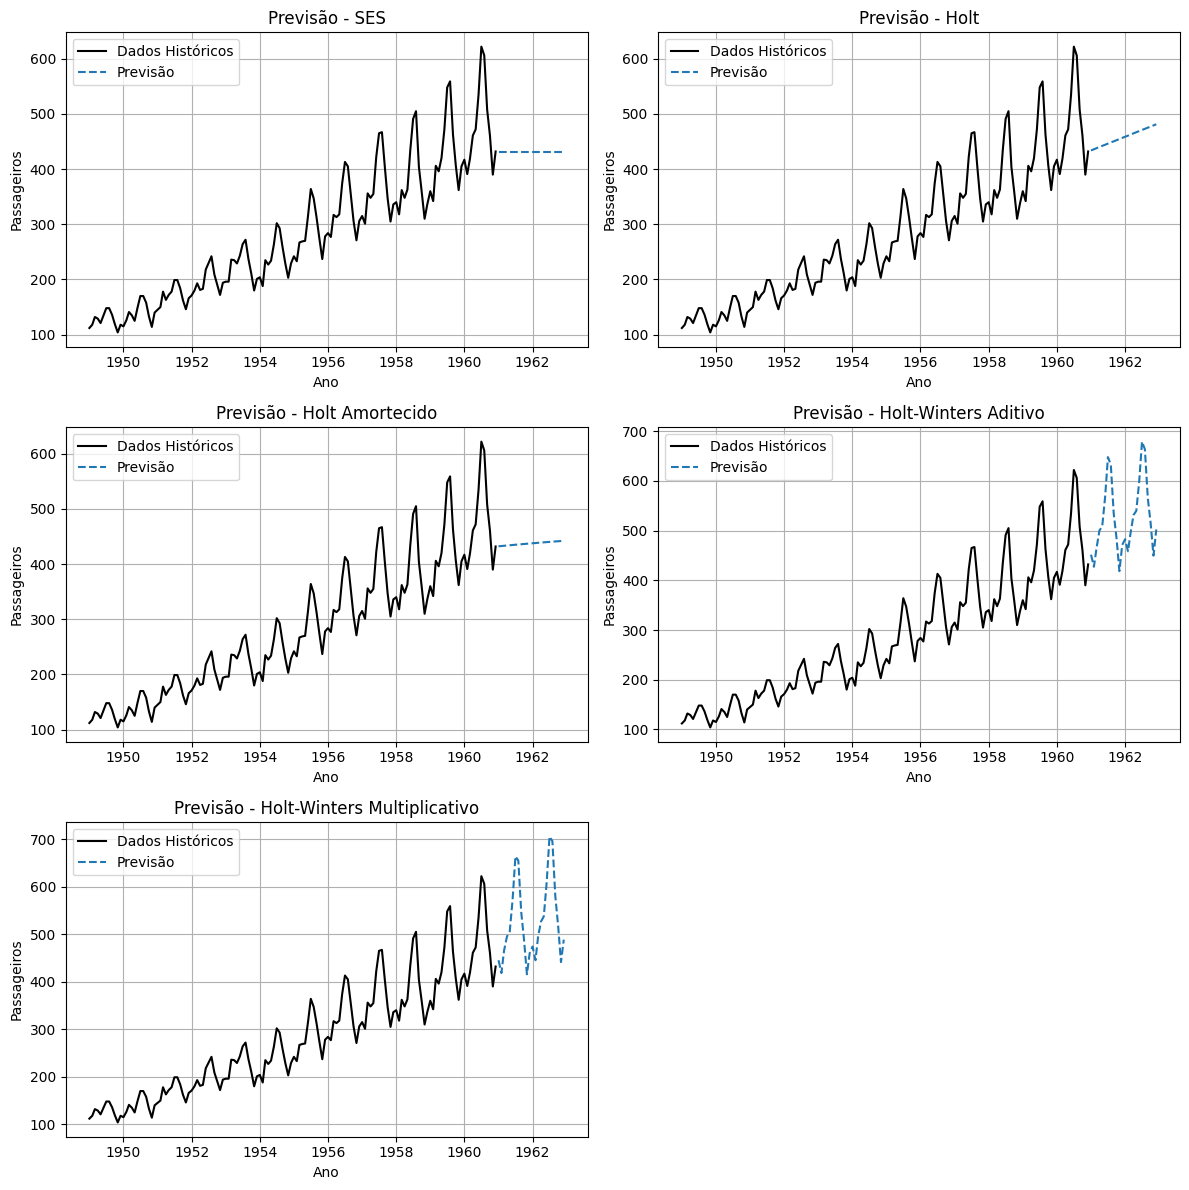

In [65]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing
from statsmodels.api import datasets

# Carregar o conjunto de dados AirPassengers
data = datasets.get_rdataset("AirPassengers").data

# Criar uma coluna de datas com frequência mensal
data["time"] = pd.date_range(start="1949-01", periods=len(data), freq="MS")

# Definir a coluna de tempo como índice
data.set_index("time", inplace=True)

# Converter os valores em uma série temporal
y = data["value"]

# Definir o horizonte de previsão (24 meses)
h = 24  

# Criar um dicionário para armazenar os modelos
modelos = {}

# 1. Suavização Exponencial Simples (SES)
modelos["SES"] = SimpleExpSmoothing(y).fit()

# 2. Modelo de Holt (Tendência Linear)
modelos["Holt"] = ExponentialSmoothing(y, trend="add", freq="MS").fit()

# 3. Modelo de Holt Amortecido (Damped Holt)
modelos["Holt Amortecido"] = ExponentialSmoothing(y, trend="add", damped_trend=True, freq="MS").fit()

# 4. Modelo de Holt-Winters Aditivo
modelos["Holt-Winters Aditivo"] = ExponentialSmoothing(y, trend="add", seasonal="add", seasonal_periods=12, freq="MS").fit()

# 5. Modelo de Holt-Winters Multiplicativo
modelos["Holt-Winters Multiplicativo"] = ExponentialSmoothing(y, trend="add", seasonal="mul", seasonal_periods=12, freq="MS").fit()

# Criar as datas futuras para previsão
datas_futuras = pd.date_range(start=y.index[-1] + pd.DateOffset(1), periods=h, freq="MS")

# Gerar previsões para cada modelo
previsoes = {nome: modelo.forecast(h) for nome, modelo in modelos.items()}

# Criar gráficos individuais para cada modelo
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12, 12))
axes = axes.flatten()  # Transformar matriz em vetor para facilitar iteração

for i, (nome, previsao) in enumerate(previsoes.items()):
    ax = axes[i]
    ax.plot(y, label="Dados Históricos", color="black")
    ax.plot(datas_futuras, previsao, label="Previsão", linestyle="dashed")
    
    ax.set_title(f"Previsão - {nome}")
    ax.set_xlabel("Ano")
    ax.set_ylabel("Passageiros")
    ax.legend()
    ax.grid()

# Remover gráfico extra se houver número ímpar de modelos
if len(previsoes) < len(axes):
    fig.delaxes(axes[-1])

# Ajustar espaçamento entre os gráficos
plt.tight_layout()
plt.show()


Tudo junto:

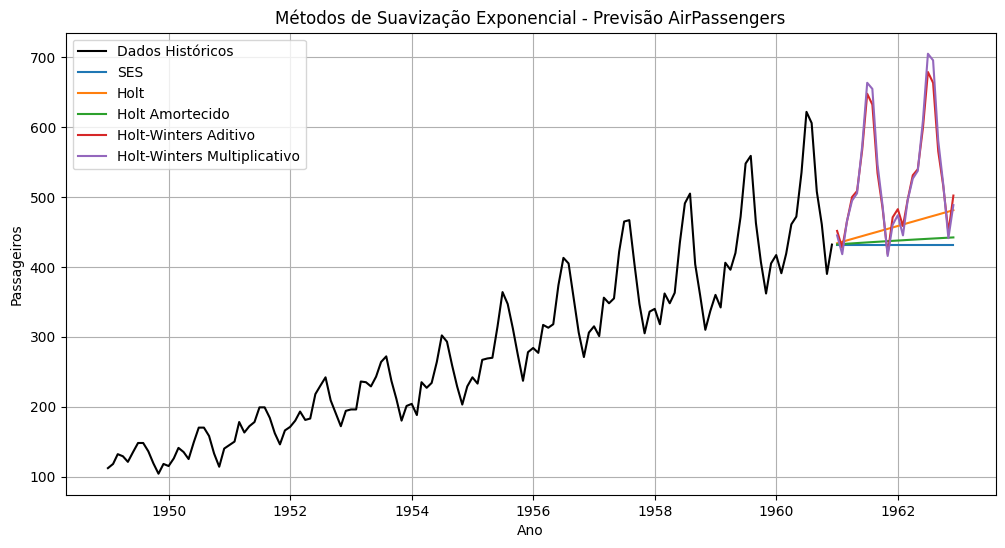

In [57]:
# Plotar os resultados
plt.figure(figsize=(12, 6))
plt.plot(y, label="Dados Históricos", color="black")

# Adicionar previsões ao gráfico
for nome, previsao in previsoes.items():
    plt.plot(datas_futuras, previsao, label=nome)

plt.title("Métodos de Suavização Exponencial - Previsão AirPassengers")
plt.xlabel("Ano")
plt.ylabel("Passageiros")
plt.legend()
plt.grid()
plt.show()

In [68]:
lancamentos

date_added
2016-01-01 00:00:00                                                   41
2016-02-01 00:00:00                                                   15
2016-03-01 00:00:00                                                   16
2016-04-01 00:00:00                                                   21
2016-05-01 00:00:00                                                   11
                                             ...                        
2021-06-01 00:00:00                                                  207
2021-07-01 00:00:00                                                  257
2021-08-01 00:00:00                                                  178
2021-09-01 00:00:00                                                  183
time                   DatetimeIndex(['1949-01-01', '1949-02-01', '19...
Length: 70, dtype: object

In [72]:



# Converter os valores em uma série temporal
y = lancamentos.values

# Definir o horizonte de previsão (24 meses)
h = 24  

# Criar um dicionário para armazenar os modelos
modelos = {}

# 1. Suavização Exponencial Simples (SES)
modelos["SES"] = SimpleExpSmoothing(y).fit()

# 2. Modelo de Holt (Tendência Linear)
modelos["Holt"] = ExponentialSmoothing(y, trend="add", freq="MS").fit()

# 3. Modelo de Holt Amortecido (Damped Holt)
modelos["Holt Amortecido"] = ExponentialSmoothing(y, trend="add", damped_trend=True, freq="MS").fit()

# 4. Modelo de Holt-Winters Aditivo
modelos["Holt-Winters Aditivo"] = ExponentialSmoothing(y, trend="add", seasonal="add", seasonal_periods=12, freq="MS").fit()

# 5. Modelo de Holt-Winters Multiplicativo
modelos["Holt-Winters Multiplicativo"] = ExponentialSmoothing(y, trend="add", seasonal="mul", seasonal_periods=12, freq="MS").fit()

# Criar as datas futuras para previsão
datas_futuras = pd.date_range(start=lancamentos.index[-1] + pd.DateOffset(1), periods=h, freq="MS")

# Gerar previsões para cada modelo
previsoes = {nome: modelo.forecast(h) for nome, modelo in modelos.items()}

# Criar gráficos individuais para cada modelo
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12, 12))
axes = axes.flatten()  # Transformar matriz em vetor para facilitar iteração

for i, (nome, previsao) in enumerate(previsoes.items()):
    ax = axes[i]
    ax.plot(y, label="Dados Históricos", color="black")
    ax.plot(datas_futuras, previsao, label="Previsão", linestyle="dashed")
    
    ax.set_title(f"Previsão - {nome}")
    ax.set_xlabel("Ano")
    ax.set_ylabel("Passageiros")
    ax.legend()
    ax.grid()

# Remover gráfico extra se houver número ímpar de modelos
if len(previsoes) < len(axes):
    fig.delaxes(axes[-1])

# Ajustar espaçamento entre os gráficos
plt.tight_layout()
plt.show()


ValueError: setting an array element with a sequence.